## Random Forest in action

You're task will be to build a Random Forest Regressor for the London Bike Sharing dataset.
The file is given below.

Target column => "cnt"

Your solution solution should consist of the following parts:
1. Data Preprocessing/Cleaning
2. Builidng RF model
3. Optimizing RF model

Think ahead of metrics you'll use, how to split data and if cross-validation is needed.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np
#import other packages you'll need

In [2]:
filename = 'london_merged.csv'

In [3]:
#Source: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

#Don't think too much about the getDataset method. It is used for convenience
def getDataset(filename, **kwargs):
    url = f'https://github.com/IvanReznikov/mdx-msc-data-science/raw/main/datasets/{filename}'
    try:
        import os
        if filename not in os.listdir():
            !pip install wget
            import wget
            downloaded_filename = wget.download(url)
            print(f'{downloaded_filename} file downloaded')
        else:
            print(f'{filename} already exists')
        return pd.read_csv(filename, **kwargs)
        
    except Exception as e:
        print(e)
        return pd.read_csv(url, **kwargs)

In [4]:
df = getDataset(filename)
df.head()

london_merged.csv already exists


,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [15]:
pd.get_dummies(df['weather_code'])

,1.0,2.0,3.0,4.0,7.0,10.0,26.0
0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
17409,0,0,1,0,0,0,0
17410,0,0,0,1,0,0,0
17411,0,0,0,1,0,0,0
17412,0,0,0,1,0,0,0


Preprocessing operations:
- check for null values => isnull, isna
- check for outliers
- transform columns:
-- convert season and weather_code to categorical or pd.dummies
-- convert timestamp to pd.to_datetime(df['timestamp']) and try <b>pd.to_datetime(df['timestamp']).dt.day</b>
-- convert is_holiday, is_weekend to bool
- remove correlations
-- PCA
-- df.corr() -- heatmap

consider train split parameters

In [5]:
df.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')

In [6]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

df_X = columns from t1 -> season
df_y = cnt column

In [7]:
evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

In [8]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [9]:
target = "cnt"
feature_names = [x for x in df.columns if (x != target and x!= 'timestamp')]
df_X = df[feature_names]
df_y = df[target]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state = 42, n_jobs=-1).fit(X_train, y_train)
pred = rf.predict(X_test)

rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrcm = float(format(rf.score(X_train,y_train),'.3f'))
artrcm = float(format(adjustedR2(rf.score(X_train,y_train),X_train.shape[0],len(feature_names)),'.3f'))
rtecm = float(format(rf.score(X_test,y_test),'.3f'))
artecm = float(format(adjustedR2(rf.score(X_test,y_test),X_test.shape[0],len(feature_names)),'.3f'))
cv = float(format(cross_val_score(rf,df[feature_names],df['cnt'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Random Forest-100',f'--depth:10',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]

In [10]:
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Random Forest-100,--depth:10,268.711,0.952,0.952,0.939,0.939,0.914


Text(0, 0.5, 'Mean decrease in impurity')

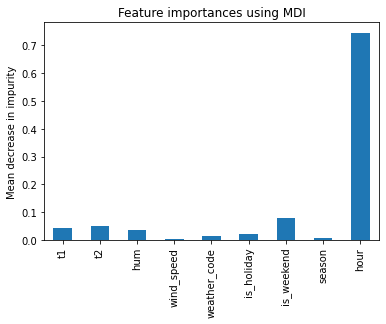

In [11]:
import matplotlib.pyplot as plt        

importances = rf.feature_importances_   
forest_importances = pd.Series(importances, index=feature_names)   
fig, ax = plt.subplots()   
forest_importances.plot.bar(ax=ax)   
ax.set_title("Feature importances using MDI")   
ax.set_ylabel("Mean decrease in impurity")